In [2]:
# Importing all the necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline


In [42]:
# Finding the keys in the train and test .h5 file to name the label and feature

# Inspect the Train.h5 file
with h5py.File('dataset/Train.h5', "r") as train_dataset:
    print("Train.h5 keys:", list(train_dataset.keys()))

# Inspect the Test.h5 file
with h5py.File('dataset/Test.h5', "r") as test_dataset:
    print("Test.h5 keys:", list(test_dataset.keys()))

Train.h5 keys: ['images', 'labels']
Test.h5 keys: ['images', 'labels']


In [43]:
# Loading the train and test dataset and reshape them to the correct dimensions

def load_dataset():
    # Load the training set
    train_dataset = h5py.File('dataset/Train.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:])  # Training set features (images)
    train_set_y_orig = np.array(train_dataset["labels"][:])  # Training set labels

    # Load the test set
    test_dataset = h5py.File('dataset/Test.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:])  # Test set features (images)
    test_set_y_orig = np.array(test_dataset["labels"][:])  # Test set labels

    # Extract unique classes from the training labels
    classes = np.unique(train_set_y_orig)

    # Reshape labels to have the correct dimensions (1, m_train) and (1, m_test)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [44]:
# Using the loaded dataset 
train_x, train_y, test_x, test_y, classes = load_dataset()
train_y = train_y.T
test_y = test_y.T

In [45]:
# Dimensions of the train and test dataset 
print(f"Training data shape: {train_x.shape}")
print(f"Training labels shape: {train_y.T.shape}")
print(f"Test data shape: {test_x.shape}")
print(f"Test labels shape: {test_y.T.shape}")

Training data shape: (2626, 128, 128, 3)
Training labels shape: (1, 2626)
Test data shape: (120, 128, 128, 3)
Test labels shape: (1, 120)


IndexError: index 1 is out of bounds for axis 1 with size 1

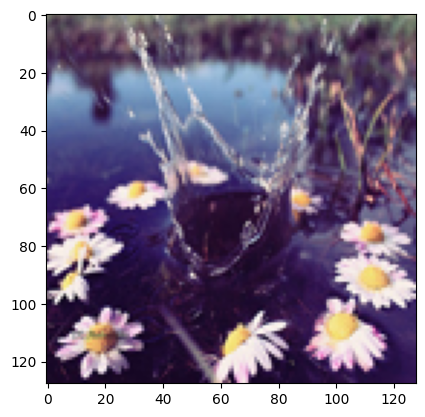

In [46]:
# Example of a picture
index = 1
plt.imshow(train_x[index])
print("y = " + str(train_y[:, index]) + ", it's a '" + num_classes[np.squeeze(train_set_y[:, index])] + "' picture.")

In [47]:
len(train_y)

2626

In [48]:
# Flatten the images and normalize pixel values to range [0, 1]
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T / 255.
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T / 255.

In [72]:
# Pritng the size before and after flattening
print("train_x shape" +str((train_x.shape)))
print ("train_x flatten shape: " + str(train_x_flatten.shape))

print("test_x shape" + str((test_x.shape)))
print ("test_x flatten shape: " + str(test_x_flatten.shape))

train_x shape(2626, 128, 128, 3)
train_x flatten shape: (49152, 2626)
test_x shape(120, 128, 128, 3)
test_x flatten shape: (49152, 120)


In [50]:
# Get unique classes from training labels
unique_classes = np.unique(train_y)

# Number of classes
num_classes = len(unique_classes)

print(f"Number of classes: {num_classes}")
print(f"Unique classes: {unique_classes}")

Number of classes: 5
Unique classes: [0 1 2 3 4]


In [51]:
# Printing the flattended and one-hot shape of train and test dataset
num_classes = 5 
train_y = convert_to_one_hot(train_y, num_classes)
test_y = convert_to_one_hot(test_y, num_classes)

print(f"Training data (flattened) shape: {train_x_flatten.shape}")
print(f"Training labels (one-hot) shape: {train_y.shape}")
print(f"Test data (flattened) shape: {test_x_flatten.shape}")
print(f"Test labels (one-hot) shape: {test_y.shape}")

Training data (flattened) shape: (49152, 2626)
Training labels (one-hot) shape: (5, 2626)
Test data (flattened) shape: (49152, 120)
Test labels (one-hot) shape: (5, 120)


In [52]:
# Softmax activation function
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [53]:
#initialize_with_zeros

def initialize_with_zeros(dim,num_classes):
    
    w = np.zeros((dim,num_classes))
    b = np.zeros((num_classes,))
    
    return w, b

In [54]:
# Defining cost function 

def compute_cost(Y_hat, Y):
    m = Y.shape[1]
    cost = -np.sum(np.multiply(Y, np.log(Y_hat))) / m
    return np.squeeze(cost)

In [55]:
def propagate(w, b, X, Y):    
    m = X.shape[1]
    Z = np.dot(w.T, X) + b[:, np.newaxis]                           
    A = softmax(Z)                                    
    cost = -np.sum(Y * np.log(A)) / m
    
    dZ = A - Y
    dw = (np.dot(X, dZ.T))/m
    db = (np.sum(A-Y))/m
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [56]:
# define optimizer and perfrom forward and back propogation
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):

    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        w -= learning_rate * dw
        b -= learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [73]:
# make predictions
def predict(w, b, X):
    Z = np.dot(w.T, X) + b.reshape(-1, 1)
    A = softmax(Z)
    
    Y_prediction = np.argmax(A, axis=0).reshape(1, X.shape[1])
    return Y_prediction

In [64]:
#define model 
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.01, print_cost=False):

    num_classes = Y_train.shape[0]
    num_features = X_train.shape[0]
    
    w,b = initialize_with_zeros(num_features, num_classes)
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    train_accuracy = 100 - np.mean(Y_prediction_train != np.argmax(Y_train, axis=0)) * 100
    test_accuracy = 100 - np.mean(Y_prediction_test != np.argmax(Y_test, axis=0)) * 100

    print("train accuracy: {} %".format(train_accuracy))
    print("test accuracy: {} %".format(test_accuracy))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train": Y_prediction_train, 
         "w": w, 
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}
    
    return d


In [66]:
#perform interations on the model 
m = model(train_x_flatten, train_y, test_x_flatten, test_y, num_iterations=2000, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 1.609438
Cost after iteration 100: 12.572498
Cost after iteration 200: 8.962723
Cost after iteration 300: 15.005446
Cost after iteration 400: 10.805070
Cost after iteration 500: 8.597038
Cost after iteration 600: 5.483665
Cost after iteration 700: 8.585497
Cost after iteration 800: 10.881545
Cost after iteration 900: 9.941103
Cost after iteration 1000: 6.842594
Cost after iteration 1100: 7.283395
Cost after iteration 1200: 8.712436
Cost after iteration 1300: 7.184051
Cost after iteration 1400: 5.807845
Cost after iteration 1500: 5.139813
Cost after iteration 1600: 1.533181
Cost after iteration 1700: 6.295011
Cost after iteration 1800: 5.973551
Cost after iteration 1900: 5.355735
train accuracy: 57.34958111195735 %
test accuracy: 37.5 %


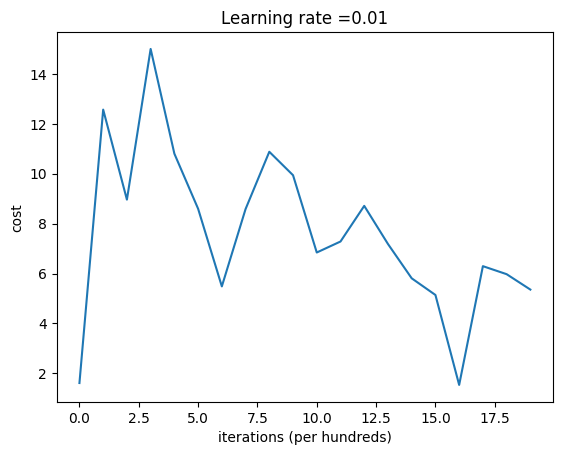

In [71]:
# represent cost 
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()